In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import pandas as pd
import numpy as np

from matplotlib import cm

class Database:
    Database = None
    Cursor = None

    def Initialize():
        Database.Database = mysql.connector.connect(
            host="localhost",
            user="WSN",
            password="wsn123", 
            database='WSN2',
            auth_plugin='mysql_native_password'
        )
        
        Database.Cursor = Database.Database.cursor()

    def Execute(query):
            Database.Cursor.execute(query)
            myresult = Database.Cursor.fetchall()
            
            ret = []
            for res in myresult:
                ret.append(res)

            return ret
    
def ListOfTuplesToLists(input):
     return list(map(list, zip(*input)))

Database.Initialize()

In [43]:

def PlotWSN(simulation_id):
    SN_level_colors = [(0.0, 1.0, 0.0, 1.0), (0.0, 0.0, 1.0, 1.0), (0.5, 0.0, 0.5, 1.0)]
    pos_x, pos_y, parent, level = ListOfTuplesToLists(Database.Execute(f'''select SensorNode.PosX, SensorNode.PosY, SensorNode.Parent, SensorNode.Level_ from 
                       SensorNode where SensorNode.SimulationID = {simulation_id}'''))
    
    fig, ax = plt.subplots()

    ax.set_title(f'Sensor Node Locations')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim(-150, 150)
    ax.set_ylim(-150, 150)
    for x in range(len(pos_x)):
        if parent[x] != -1:
            ax.plot([pos_x[parent[x]], pos_x[x]], [pos_y[parent[x]], pos_y[x]], c=(0.7411764706, 0.7411764706, 0.7411764706, 1.0), zorder=-1)
        else:
            ax.plot([0, pos_x[x]], [0, pos_y[x]], c=(0.7411764706, 0.7411764706, 0.7411764706, 1.0),zorder=-1)
    for x in range(len(pos_x)):
        ax.scatter(pos_x[x], pos_y[x], c=SN_level_colors[level[x]], zorder=1)
    ax.scatter([0], [0], c=(1.0, 0.0, 0.0, 1.0), zorder=1)

    for i in [50, 100, 150]:
        ax.add_artist(plt.Circle( (0.0, 0.0 ), i, fill = False ))

    #plt.legend(['Sensor Node Location'])
    plt.show()



def PlotCorrelationCWSN_MTBF():
    #x, y = ListOfTuplesToLists(Database.Execute(f'''select Simulation.FailureMean, Simulation.CWSNEfficiency from 
    #                   Simulation where Simulation.FailureDistributionType = 'Exponential' '''))
    
    #dicti = {'MTBF' : x, 'CWSNEfficiency' : y}
    #df = pd.DataFrame(dicti)
    #sns.regplot(x='MTBF', y='CWSNEfficiency', data=df)

    def plot3d(distributionType):
        x, y, z = ListOfTuplesToLists(Database.Execute(f'''select Simulation.FailureMean, Simulation.FailureStddev, Simulation.CWSNEfficiency from 
                       Simulation where Simulation.FailureDistributionType = '{distributionType}' order by Simulation.FailureMean, Simulation.FailureStddev'''))
        
        mean_count = ListOfTuplesToLists(Database.Execute(f'''select count(*) from 
                       Simulation where Simulation.FailureDistributionType = '{distributionType}' group by Simulation.FailureMean '''))[0][0]
        stddev_count = ListOfTuplesToLists(Database.Execute(f'''select count(*) from 
                       Simulation where Simulation.FailureDistributionType = '{distributionType}' group by Simulation.FailureStddev '''))[0][0]
        
        x = list(set(list(x)))
        y = list(set(list(y)))
        x.sort()
        y.sort()
        print(x)
        print(y)
        print(z)



        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        y,x=np.meshgrid(np.array(y),np.array(x))
        #x = np.array(x)
        #y = np.array(y)
        z=np.reshape(np.array(z),(-1,mean_count))

        print(x.shape)
        print(y.shape)
        print(z.shape)
        print('this is x\n')
        print(x)
        print('this is y\n')
        print(y)
        print('this is z\n')
        print(z)

        ax.set_xlabel('FailureMean')
        ax.set_ylabel('FailureStddev')
        ax.set_zlabel('CWSN')

        my_col = cm.jet(z/np.amax(z))
        surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm)
        ax.set_zlim(0, 1)
        #ax.zaxis.set_major_locator(LinearLocator(10))
        #ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
        #ax.xaxis.set_major_formatter(FuncFormatter(format_log))
        #ax.yaxis.set_major_formatter(FuncFormatter(format_log))
        fig.colorbar(surf, shrink=0.5, aspect=5)
        plt.show()
        
    #for distributionType in ['Weibull', 'Gamma', 'Lognormal']:
    for distributionType in ['Weibull']:
        plot3d(distributionType)




def PlotDelay_Level():
    x, y = ListOfTuplesToLists(Database.Execute(f'''select SensorNode.Level_, sum(SensorNode.SentPacketTotalDelay) / sum(SensorNode.SentPacketCount) 
                                                from SensorNode where SensorNode.Level_ is not null group by SensorNode.Level_;'''))
    fig, ax = plt.subplots()

    ax.bar(x, y)
    
    ax.set_title(f'Sensor Node Locations')
    ax.set_xlabel('Level')
    ax.set_ylabel('Average Packet Delay')
    plt.show()


def PlotCorrelationEnergyConsumed_DeltaOpt():
    x, y = ListOfTuplesToLists(Database.Execute(f'''select SensorNode.DeltaOpt, SensorNode.EnergyConsumed from 
                       SensorNode where SensorNode.DeltaOpt < 1500 and SensorNode.DeltaOpt > 10'''))
    
    dicti = {'DeltaOpt' : x, 'EnergyConsumed' : y}
    df = pd.DataFrame(dicti)
    sns.regplot(x='DeltaOpt', y='EnergyConsumed', data=df)


def PlotCorrelationCollectionTime_DeltaOpt():
    x, y = ListOfTuplesToLists(Database.Execute(f'''select SensorNode.DeltaOpt, SensorNode.CollectionTime from 
                       SensorNode where SensorNode.DeltaOpt < 1500 and SensorNode.DeltaOpt > 10'''))
    
    dicti = {'DeltaOpt' : x, 'CollectionTime' : y}
    df = pd.DataFrame(dicti)
    sns.regplot(x='DeltaOpt', y='CollectionTime', data=df)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_11668\2521148825.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(pos_x[x], pos_y[x], c=SN_level_colors[level[x]], zorder=1)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_11668\2521148825.py:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([0], [0], c=(1.0, 0.0, 0.0, 1.0), zorder=1)


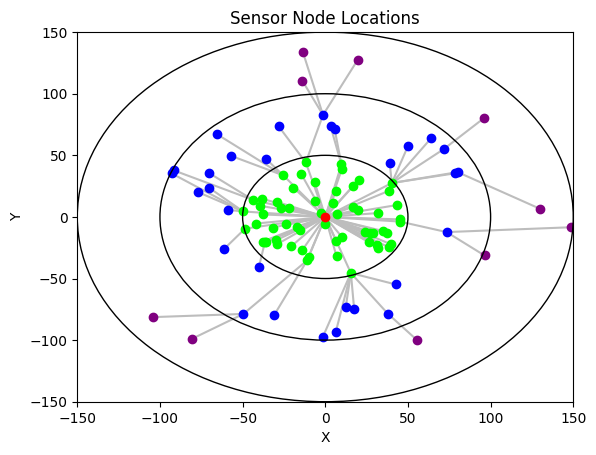

In [44]:
PlotWSN(1)

[3600.0, 4500.0, 5400.0, 6300.0, 7200.0]
[3600.0, 4500.0, 5400.0, 6300.0, 7200.0]
[0.8152026700392312, 0.8210636018815433, 0.8068989803627578, 0.8207619581738941, 0.8148049580641934, 0.8374022414528142, 0.8290231107510752, 0.8375764906580545, 0.8306582364460752, 0.8299708284301041, 0.8489263106572758, 0.8497559768272477, 0.843529158817911, 0.8431061674904392, 0.8334937714656501, 0.8457026042031296, 0.8536352433938874, 0.854454481170002, 0.858994809039585, 0.860331757030295, 0.8668990634850663, 0.8531974640172821, 0.8619127991525555, 0.8604096268535006, 0.8606068813698302]
(5, 5)
(5, 5)
(5, 5)
this is x

[[3600. 3600. 3600. 3600. 3600.]
 [4500. 4500. 4500. 4500. 4500.]
 [5400. 5400. 5400. 5400. 5400.]
 [6300. 6300. 6300. 6300. 6300.]
 [7200. 7200. 7200. 7200. 7200.]]
this is y

[[3600. 4500. 5400. 6300. 7200.]
 [3600. 4500. 5400. 6300. 7200.]
 [3600. 4500. 5400. 6300. 7200.]
 [3600. 4500. 5400. 6300. 7200.]
 [3600. 4500. 5400. 6300. 7200.]]
this is z

[[0.81520267 0.8210636  0.80689898 

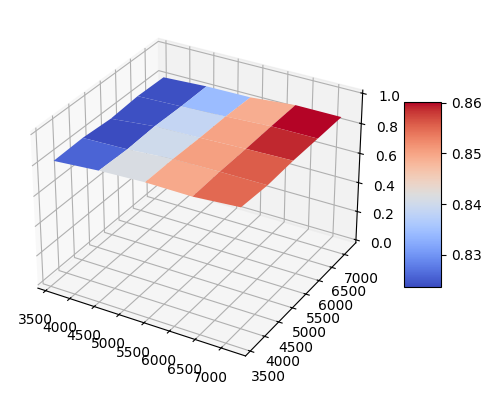

In [45]:
PlotCorrelationCWSN_MTBF()

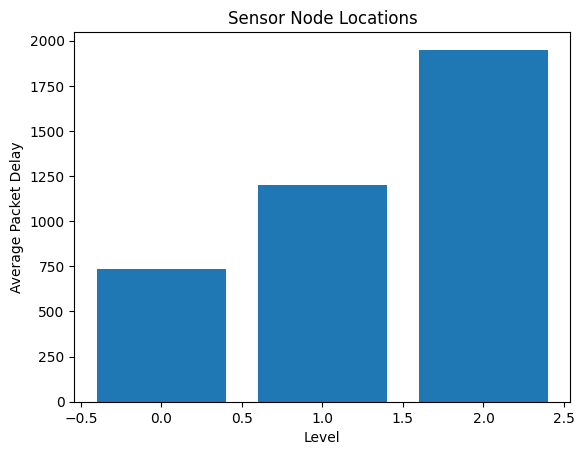

In [46]:
PlotDelay_Level()

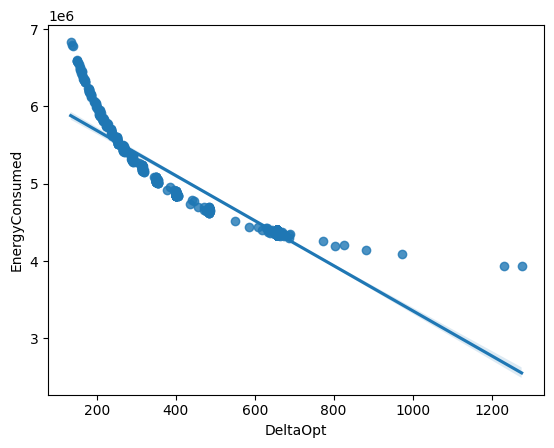

In [ ]:
PlotCorrelationEnergyConsumed_DeltaOpt()

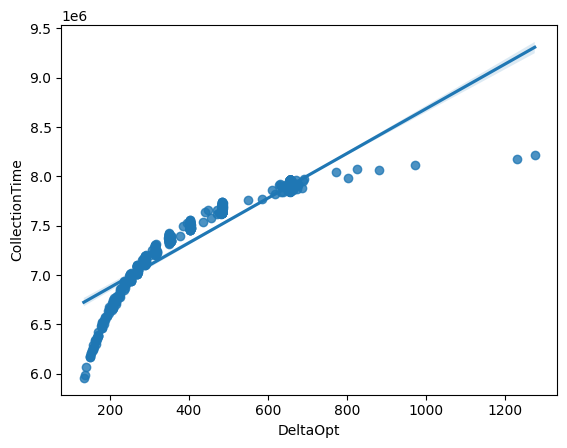

In [ ]:
PlotCorrelationCollectionTime_DeltaOpt()